## Mission 2

이번 미션에서는 start codon 주변에서 ribosome-protected fragment의 분포를 한 번 살펴보겠습니다. 보통은 RPF의 5'-end 분포가 start codon 앞 15nt 정도에서부터 본격적으로 많이 나오고, 거기서부터 CDS를 걸쳐서 3nt 주기로 올록볼록한 패턴이 나타납니다.

이 그림을 제대로 그리려면 genome coordinate를 start codon을 기준으로 변환해서 작업해야 하지만, 이번 미션에서는 난이도를 적절히 내리기 위해서 start codon이 포함된 exon에 존재하는 5' end만 추려서 작업하도록 합시다. (여유가 좀 있어서 난이도를 적당히 올리고 싶은 분들은 negative strand를 포함할 수도 있고, start codon과 다른 exon에 있는 경우를 포함할 수도 있습니다. 또한 APPRIS 등을 기반으로 해서 transcript 중에 가장 )

In [1]:
%cd /qbio/junsoopablo/2022_bioinfo/project/binfo1-datapack1

/qbio/junsoopablo/2022_bioinfo/project/binfo1-datapack1


In [125]:
import numpy as np
import pickle
from sklearn import decomposition
from scipy.stats import spearmanr
from functools import reduce
import matplotlib.ticker as ticker
from Bio.Seq import Seq
from Bio.SeqUtils import GC
from Bio import SeqIO
import matplotlib.colors as mcolors
import pylab as pl
from collections import Counter
from matplotlib import colors as colors

plt.style.use('default')
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
sns.set_style("whitegrid")

# fig.patch.set_facecolor('white')
%matplotlib inline

우선 annotation에서 start codon이 포함된 exon만 추립니다. Gene 한 개에 isoform이 여러 개 있는 경우 모두 쓰면 read가 너무 부풀려질 수 있기 때문에 우선 transcript support level이 1인 것만 추려서 사용합니다. 여전히 TSL 1만 쓰더라도 부풀려질 가능성은 있기 때문에 제대로 하자면 APPRIS나 RNA-seq 데이터 기준으로 하나만 선정하는 것이 좋습니다만, 일단 여기서는 간단히..

그리고, - strand가 들어가면 좀 계산이 복잡해지니까 또 간단하게 하기 위해서 + strand만 고릅니다. 이번엔 일단 무조건 간단하게 해 봅시다~

In [3]:
!grep '	start_codon	.*	+	.*transcript_support_level "1"' gencode.gtf | \
 sed -e 's/	[^	]*transcript_id "\([^"]*\)".*$/	\1/g' > gencode-start.gtf
!head gencode-start.gtf

chr1	HAVANA	start_codon	4878137	4878139	.	+	0	ENSMUST00000134384.8
chr1	HAVANA	start_codon	4878137	4878139	.	+	0	ENSMUST00000027036.11
chr1	HAVANA	start_codon	4878137	4878139	.	+	0	ENSMUST00000150971.8
chr1	HAVANA	start_codon	4928137	4928139	.	+	0	ENSMUST00000081551.14
chr1	HAVANA	start_codon	5154674	5154676	.	+	0	ENSMUST00000044369.13
chr1	HAVANA	start_codon	5659272	5659274	.	+	0	ENSMUST00000160777.8
chr1	HAVANA	start_codon	5659272	5659274	.	+	0	ENSMUST00000027038.11
chr1	HAVANA	start_codon	6300227	6300229	.	+	0	ENSMUST00000027040.13
chr1	HAVANA	start_codon	6429555	6429557	.	+	0	ENSMUST00000133144.4
chr1	HAVANA	start_codon	6839122	6839124	.	+	0	ENSMUST00000140079.8


start codon가 들어가 있는 exon들을 고르기 위해서 미리 + strand에 있는 exon를 추립니다.. start codon 쪽에서 TSL 기준으로 골랐기 때문에 여기서는 고르지 않아도 됩니다. 물론 좀 느려지기는 하지만...

In [4]:
!grep '	exon	.*	+	' gencode.gtf | \
 sed -e 's/	[^	]*transcript_id "\([^"]*\)".*$/	\1/g' > gencode-plusexon.gtf
!head gencode-plusexon.gtf

chr1	HAVANA	exon	3143476	3144545	.	+	.	ENSMUST00000193812.2
chr1	ENSEMBL	exon	3172239	3172348	.	+	.	ENSMUST00000082908.3
chr1	HAVANA	exon	3322980	3323459	.	+	.	ENSMUST00000192857.2
chr1	HAVANA	exon	3536810	3536910	.	+	.	ENSMUST00000161581.2
chr1	HAVANA	exon	3583628	3583776	.	+	.	ENSMUST00000161581.2
chr1	HAVANA	exon	3602018	3602943	.	+	.	ENSMUST00000192183.2
chr1	HAVANA	exon	3750378	3752011	.	+	.	ENSMUST00000193244.2
chr1	HAVANA	exon	3822233	3824583	.	+	.	ENSMUST00000194454.2
chr1	HAVANA	exon	4566774	4569601	.	+	.	ENSMUST00000193450.2
chr1	HAVANA	exon	4567697	4567877	.	+	.	ENSMUST00000194935.2


그 다음엔 exon 리스트와 start codon 리스트를 겹치고, transcript가 같은 것만 살려둡니다. 기왕 좀 다루기 쉽도록 출력은 bed로 하면서 좌표계를 바꿉니다. 결과는 bedtools에서 빠르게 다룰 수 있게 sort해 둡니다.

In [5]:
!bedtools intersect -a gencode-start.gtf -b gencode-plusexon.gtf -wa -wb | \
 awk -F'	' -v OFS='	' '$9 == $18 { print $10, $13-1, $14, $18, $4-1, $16; }' | \
 sort -k1,1 -k2,3n -k4,4 > gencode-exons-containing-startcodon.bed
!head gencode-exons-containing-startcodon.bed; tail gencode-exons-containing-startcodon.bed

chr1	4878010	4878205	ENSMUST00000134384.8	4878136	+
chr1	4878045	4878205	ENSMUST00000027036.11	4878136	+
chr1	4878052	4878205	ENSMUST00000150971.8	4878136	+
chr1	4928036	4928199	ENSMUST00000081551.14	4928136	+
chr1	5154639	5154786	ENSMUST00000044369.13	5154673	+
chr1	5659227	5659528	ENSMUST00000027038.11	5659271	+
chr1	5659257	5659528	ENSMUST00000160777.8	5659271	+
chr1	6300182	6300297	ENSMUST00000027040.13	6300226	+
chr1	6429441	6429738	ENSMUST00000133144.4	6429554	+
chr1	6839121	6839176	ENSMUST00000043578.13	6839121	+
chrY	80939672	80939804	ENSMUST00000185340.2	80939686	+
chrY	81470683	81470815	ENSMUST00000187135.2	81470697	+
chrY	82237903	82238035	ENSMUST00000185636.2	82237917	+
chrY	83043623	83043755	ENSMUST00000187165.2	83043637	+
chrY	84109956	84110088	ENSMUST00000185776.7	84109970	+
chrY	84759361	84759493	ENSMUST00000186110.2	84759375	+
chrY	86074448	86074580	ENSMUST00000188754.2	86074462	+
chrY	87129500	87129632	ENSMUST00000189543.7	87129514	+
chrY	87563647	87563779	ENSMUST0000

컬럼 4번에 transcript id, 5번에 start codon 위치를 넣었는데, start codon이 같은 것들이 여러개 눈에 띕니다. 아주 찝찝하지만, 우선 이번은 간단하게 할 것이기 때문에 눈을 질끈 감고 넘어가 봅시다.

이제 alignment를 준비합니다. + strand alignment에서 read length가 짧은 것도 미리 필터링 합니다. RPF는 보통 25nt 이상이기 때문에 그 이하는 거의 확실히 rRNA, tRNA 등에서 오염된 것들입니다. SAM 파일 전체를 필터링해서 다시 인코딩하기 때문에 시간이 좀 걸립니다.

In [6]:
!(samtools view -H RPF-siLuc.bam; \
  samtools view -F20 RPF-siLuc.bam | \
  bioawk -c sam '{ if (length($seq) >= 25) print $0; }') | \
 samtools view -b -o filtered-RPF-siLuc.bam

In [128]:
!(samtools view -H RPF-siLin28a.bam; \
  samtools view -F20 RPF-siLin28a.bam | \
  bioawk -c sam '{ if (length($seq) >= 25) print $0; }') | \
 samtools view -b -o filtered-RPF-siLin28a.bam

큰 일을 했으니 용량을 한 번 봅니다.

In [7]:
!ls -al *RPF-siLuc.bam

-rw-r--r-- 1 junsoopablo qbio  578280809 May  6 13:11 filtered-RPF-siLuc.bam
-rw-r--r-- 1 junsoopablo qbio 1055123479 May  6  2021 RPF-siLuc.bam


In [129]:
!ls -al *RPF-siLin28a.bam

-rw-r--r-- 1 junsoopablo qbio 409734417 May  6 14:11 filtered-RPF-siLin28a.bam
-rw-r--r-- 1 junsoopablo qbio 737352902 May  6  2021 RPF-siLin28a.bam


자 이제 read의 5' end 위치를 셉니다. bedtools의 `genomecov`를 쓰면 아주 편리합니다.

In [8]:
!bedtools genomecov -ibam filtered-RPF-siLuc.bam -bg -5 > fivepcounts-RPF-siLuc.bed
!head fivepcounts-RPF-siLuc.bed

chr1	3176534	3176535	1
chr1	3196256	3196257	1
chr1	3221526	3221527	1
chr1	3221542	3221543	2
chr1	3221545	3221546	3
chr1	3221546	3221547	2
chr1	3221548	3221550	1
chr1	3221571	3221572	1
chr1	3221897	3221898	1
chr1	3221994	3221995	1


In [130]:
!bedtools genomecov -ibam filtered-RPF-siLin28a.bam -bg -5 > fivepcounts-RPF-siLin28a.bed
!head fivepcounts-RPF-siLin28a.bed

chr1	3123359	3123360	1
chr1	3124284	3124285	1
chr1	3188296	3188297	1
chr1	3221546	3221547	1
chr1	3221549	3221550	2
chr1	3221868	3221869	1
chr1	3222153	3222154	1
chr1	3222413	3222415	1
chr1	3222638	3222639	1
chr1	3224556	3224557	1


그렇게 match 된 것들 중에 앞에서 찾은 start codon을 포함한 exon과 겹치는 것만 골라냅니다.

In [9]:
!bedtools intersect -a fivepcounts-RPF-siLuc.bed -b gencode-exons-containing-startcodon.bed \
 -wa -wb -nonamecheck > fivepcounts-filtered-RPF-siLuc.txt
!head fivepcounts-filtered-RPF-siLuc.txt

chr1	4878048	4878049	1	chr1	4878010	4878205	ENSMUST00000134384.8	4878136	+
chr1	4878048	4878049	1	chr1	4878045	4878205	ENSMUST00000027036.11	4878136	+
chr1	4878077	4878078	1	chr1	4878010	4878205	ENSMUST00000134384.8	4878136	+
chr1	4878077	4878078	1	chr1	4878045	4878205	ENSMUST00000027036.11	4878136	+
chr1	4878077	4878078	1	chr1	4878052	4878205	ENSMUST00000150971.8	4878136	+
chr1	4878101	4878102	4	chr1	4878010	4878205	ENSMUST00000134384.8	4878136	+
chr1	4878101	4878102	4	chr1	4878045	4878205	ENSMUST00000027036.11	4878136	+
chr1	4878101	4878102	4	chr1	4878052	4878205	ENSMUST00000150971.8	4878136	+
chr1	4878103	4878104	1	chr1	4878010	4878205	ENSMUST00000134384.8	4878136	+
chr1	4878103	4878104	1	chr1	4878045	4878205	ENSMUST00000027036.11	4878136	+


In [131]:
!bedtools intersect -a fivepcounts-RPF-siLin28a.bed -b gencode-exons-containing-startcodon.bed \
 -wa -wb -nonamecheck > fivepcounts-filtered-RPF-siLin28a.txt
!head fivepcounts-filtered-RPF-siLin28a.txt

chr1	4878043	4878044	1	chr1	4878010	4878205	ENSMUST00000134384.8	4878136	+
chr1	4878056	4878057	3	chr1	4878010	4878205	ENSMUST00000134384.8	4878136	+
chr1	4878056	4878057	3	chr1	4878045	4878205	ENSMUST00000027036.11	4878136	+
chr1	4878056	4878057	3	chr1	4878052	4878205	ENSMUST00000150971.8	4878136	+
chr1	4878074	4878075	1	chr1	4878010	4878205	ENSMUST00000134384.8	4878136	+
chr1	4878074	4878075	1	chr1	4878045	4878205	ENSMUST00000027036.11	4878136	+
chr1	4878074	4878075	1	chr1	4878052	4878205	ENSMUST00000150971.8	4878136	+
chr1	4878089	4878090	1	chr1	4878010	4878205	ENSMUST00000134384.8	4878136	+
chr1	4878089	4878090	1	chr1	4878045	4878205	ENSMUST00000027036.11	4878136	+
chr1	4878089	4878090	1	chr1	4878052	4878205	ENSMUST00000150971.8	4878136	+


모든 준비가 끝났습니다. 이제 Figure S5A 도전해 보세요!

* stop codon은 빼고 start codon 만입니다.
* 논문에서는 처리가 어려운 부분까지 모두 포함됐고, read를 중첩해서 세지 않았기 때문에, 여기서 세는 것과는 수치는 다를 수 있습니다.
* `pandas`로 한꺼번에 데이터를 모두 불러들이면 메모리가 부족할 수도 있습니다. 그런 경우에는 chunk를 쓰거나, 줄 단위로 처리해 보세요.

In [132]:
def count_startregion(target):
    coordsreader = pd.read_csv(f'fivepcounts-filtered-RPF-{target}.txt', sep='\t', 
                            names=['rchrom', 'rstart', 'rend', 'rcount', 'exon_chr', 'exon_start', 'exon_end', 'transcript_id', 'startpos','ori'],
                            chunksize=100000)
    partialcounts = []
    for chunk in coordsreader:
        chunk['rstart'] = chunk['rstart'] - chunk['startpos']
        startregion = (chunk['rstart'].isin(range(-50,51)))
        chunk = chunk[startregion]
        chunk = chunk.groupby(['rstart']).sum()['rcount']
        chunk = chunk.reindex(range(-50,51)).fillna(0)
        if chunk.sum()>0:
            partialcounts.append(chunk)
    outdf = pd.concat(partialcounts, axis=1).fillna(0).astype(np.int64).sum(axis=1)
    outdf = outdf / 1000
    outdf = outdf.to_frame(name='count')
    return outdf

In [136]:
siLuc_df = count_startregion('siLuc')
siLin28a_df = count_startregion('siLin28a')
siLuc_df

,count
rstart,
-50,2.878
-49,2.556
-48,2.366
-47,3.442
-46,2.656
...,...
46,1.077
47,4.401
48,4.608


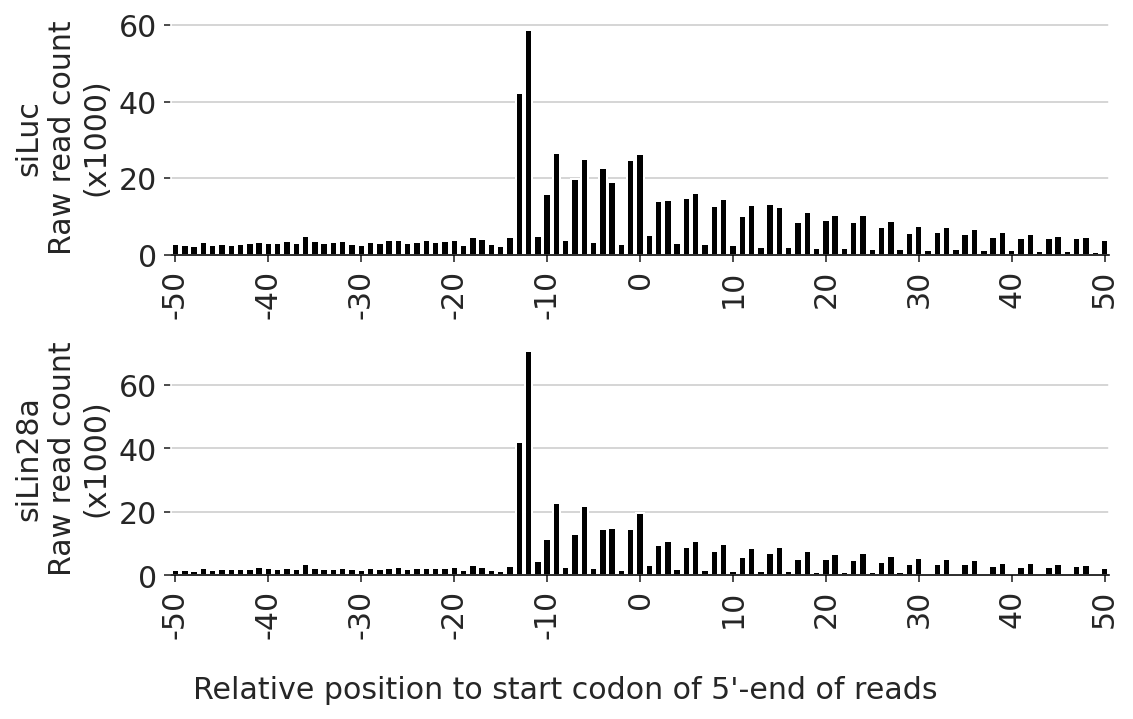

In [162]:
fig, ax = plt.subplots(2, 1, figsize=(8, 5), sharex=False)
for num, i in enumerate(['siLuc', 'siLin28a']):
    outdf = count_startregion(i)
    g = sns.barplot(data=outdf, x=outdf.index ,y='count', color='black', ax=ax[num])
    g.spines['left'].set_edgecolor(None)
    g.spines['bottom'].set_edgecolor('black')
    g.spines['top'].set_edgecolor(None)
    g.spines['right'].set_edgecolor(None)
        
    g.tick_params(top=False,
                bottom=True,
                left=True,
                right=False,
                labelbottom=True)
    g.tick_params(labelsize=15)
    ax[num].set_xticklabels(ax[num].get_xticklabels(), rotation=90)
    ax[num].xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax[num].yaxis.set_major_locator(ticker.MultipleLocator(20))

    g.set_ylabel(f"{i}\nRaw read count\n(x1000)", fontsize=15)
    g.set_xlabel('')
fig.supxlabel("Relative position to start codon of 5'-end of reads", fontsize=15)
fig.tight_layout()


In [154]:
g.get_xticklabels()

[Text(-10.0, 0, '-50'),
 Text(0.0, 0, '-49'),
 Text(10.0, 0, '-48'),
 Text(20.0, 0, '-47'),
 Text(30.0, 0, '-46'),
 Text(40.0, 0, '-45'),
 Text(50.0, 0, '-44'),
 Text(60.0, 0, '-43'),
 Text(70.0, 0, '-42'),
 Text(80.0, 0, '-41'),
 Text(90.0, 0, '-40'),
 Text(100.0, 0, '-39'),
 Text(110.0, 0, '-38')]